# ENSF 519 Final Project - Image to Caption Matcher
### Project Description: Our project outlined in the steps below tests 2 deep learning deep learning model's ability to match images to image captions using the Flickr8k Dataset, then intakes a defined image and displays the closest predicted captions.
## Team Members:
- Gashagaza, Gisa Tchaka
- Ghattas, Mohamad
- Long, Alvin
- van Roessel, Spencer

## Step 0: Imports

In [1]:
# Run in the folder that contains: captions.txt  and Images/ (Flickr8k)
# Requires: torch, torchvision, transformers, tqdm, nltk

import os, math, random
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

# HuggingFace CLIP
from transformers import CLIPProcessor, CLIPModel

import nltk
nltk.download('punkt')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/alvinlong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 1: Setup Config / Paths / Device variables

In [ ]:
DATA_DIR = Path('.')    # project folder with "captions.txt" and "Images" folder, currently in the project directory
CAPTIONS_FILE = DATA_DIR / 'captions.txt'
IMAGES_DIR = DATA_DIR / 'Images'
UPLOADED_IMAGE = "people-playing-foosball.png"  # uploaded image (for demo)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cpu


# Step 2: Helpers: load captions (CSV style)

In [5]:
def load_captions_csv(captions_file):
    # returns dict: image_filename -> list of captions
    img2caps = defaultdict(list)
    with open(captions_file, 'r', encoding='utf-8') as f:
        header = f.readline()  # skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            # split only on first comma
            img, cap = line.split(',', 1)
            img2caps[img].append(cap.strip())
    return dict(img2caps)

img2caps = load_captions_csv(CAPTIONS_FILE)
print("Images with captions:", len(img2caps))

Images with captions: 8091


## Step 3: Build splits (train/val/test)

In [ ]:
all_images = sorted(list(img2caps.keys()))
random.seed(42)
random.shuffle(all_images)
N = len(all_images)
n_test = max(500, int(0.1 * N))   # test ~10% or 500 images (can adjust)
n_val = max(500, int(0.1 * N))
test_imgs = all_images[:n_test]
val_imgs = all_images[n_test:n_test+n_val]
train_imgs = all_images[n_test+n_val:]
print("Train/Val/Test sizes:", len(train_imgs), len(val_imgs), len(test_imgs))

Train/Val/Test sizes: 6473 809 809


## Step 4: Preprocessing transforms

In [7]:
IMG_SIZE = 224
img_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

## Step 5: Dataset to produce image + single caption sample
We'll create a dataset that for each image returns a random caption among the 5

In [ ]:
class FlickrPairsDataset(Dataset):
    def __init__(self, img_list, img2caps, images_dir, transform, max_text_len=30):
        self.img_list = img_list
        self.img2caps = img2caps
        self.images_dir = Path(images_dir)
        self.transform = transform
        self.max_text_len = max_text_len
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = self.images_dir / img_name
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # choose one caption randomly for training sample
        caption = random.choice(self.img2caps[img_name])
        return image, caption, img_name

# quick datasets
train_ds = FlickrPairsDataset(train_imgs, img2caps, IMAGES_DIR, img_transform)
val_ds   = FlickrPairsDataset(val_imgs, img2caps, IMAGES_DIR, img_transform)
test_pairs = [(IMAGES_DIR / img, img2caps[img], img) for img in test_imgs]  # use all captions for retrieval

## Step 6: Utility: tokenize captions (simple nltk tokenizer)

In [9]:
def simple_tokenize(s):
    return nltk.word_tokenize(s.lower())

## 7a. Model A: CLIP baseline (HuggingFace)
- We will use CLIP to compute embeddings for all images and all captions
- Retrieval: cosine similarity between image and text embeddings

In [ ]:
print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

@torch.no_grad()
def compute_clip_embeddings(image_paths, texts, batch_size=64):
    # image_paths: list of PIL images or tensors/paths
    # texts: list of text strings (same length) -- for dataset-wide embeddings
    # returns two arrays: image_embs (N, D), text_embs (N, D)
    # process images and texts separately
    # if image_paths are PIL paths, open them
    imgs = []
    for p in image_paths:
        if isinstance(p, (str, Path)):
            im = Image.open(p).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            imgs.append(im)
        else:
            imgs.append(p)  # already PIL or tensor
    # batch process images
    all_img_embs = []
    for i in range(0, len(imgs), batch_size):
        batch = imgs[i:i+batch_size]
        proc = clip_processor(images=batch, return_tensors='pt').to(DEVICE)
        out = clip_model.get_image_features(**proc)
        emb = out.detach()
        emb = F.normalize(emb, dim=-1)
        all_img_embs.append(emb.cpu())
    all_img_embs = torch.cat(all_img_embs, dim=0)
    # texts
    all_txt_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        proc = clip_processor(text=batch, return_tensors='pt', padding=True).to(DEVICE)
        out = clip_model.get_text_features(**proc)
        emb = F.normalize(out.detach(), dim=-1)
        all_txt_embs.append(emb.cpu())
    all_txt_embs = torch.cat(all_txt_embs, dim=0)
    return all_img_embs.numpy(), all_txt_embs.numpy()

Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## 7b. Model B: Custom model (ResNet18 + BiLSTM) to produce embeddings
- We'll use pretrained ResNet18 (optionally freeze), project to embed_dim
- Text encoder: word embedding + BiLSTM -> take last hidden (or mean) -> projection
- Train with symmetric contrastive (cross-entropy on similarity logits)

In [ ]:
class ImageEncoderResNet(nn.Module):
    def __init__(self, embed_dim=512, train_resnet=False):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        # remove final fc
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])    # outputs (B,512,1,1)
        if not train_resnet:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.proj = nn.Linear(resnet.fc.in_features, embed_dim)
    
    def forward(self, x):
        # x: (B,3,H,W)
        feat = self.backbone(x).squeeze(-1).squeeze(-1) # (B,512)
        out = self.proj(feat)                               # (B,embed_dim)
        out = F.normalize(out, dim=-1)
        return out

class TextEncoderBiLSTM(nn.Module):
    def __init__(self, vocab, embed_dim=512, hidden=512, num_layers=1):
        super().__init__()
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab)+1, embedding_dim=300, padding_idx=0)
        self.lstm = nn.LSTM(input_size=300, hidden_size=hidden//2, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hidden, embed_dim)
    
    def forward(self, token_ids, lengths):
        # token_ids: (B, T)
        embedded = self.embedding(token_ids)            # (B,T,300)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        # h_n: (num_layers*2, B, hidden//2)
        h_cat = torch.cat([h_n[-2], h_n[-1]], dim=-1)   # (B, hidden)
        out = self.proj(h_cat)                          # (B, embed_dim)
        out = F.normalize(out, dim=-1)
        return out

## Step 8: Simple text tokenizer + vocab builder (small)

In [12]:
from collections import Counter
def build_vocab(img2caps, min_freq=2, max_size=10000):
    counter = Counter()
    for caps in img2caps.values():
        for c in caps:
            toks = simple_tokenize(c)
            counter.update(toks)
    words = [w for w,c in counter.items() if c >= min_freq]
    words = sorted(words, key=lambda w: -counter[w])[:max_size]
    stoi = {w:i+1 for i,w in enumerate(words)}  # 0 reserved for pad
    stoi['<unk>'] = len(stoi)+1
    itos = {i:w for w,i in stoi.items()}
    return {'stoi': stoi, 'itos': itos, 'pad': 0}

vocab = build_vocab({k:img2caps[k] for k in train_imgs}, min_freq=2)
print("Vocab size:", len(vocab['stoi']))

# convert a caption to token ids
def caption_to_ids(caption, stoi, max_len=30):
    toks = simple_tokenize(caption)[:max_len]
    ids = [stoi.get(t, stoi['<unk>']) for t in toks]
    length = len(ids)
    if length < max_len:
        ids = ids + [0] * (max_len - length)
    return ids, length

Vocab size: 4720


## Step 9: DataLoader for training custom model
Will yield batches of images and token_ids + lengths

In [13]:
class TrainPairsLoader(Dataset):
    def __init__(self, img_list, img2caps, images_dir, transform, stoi, max_len=30):
        self.img_list = img_list
        self.img2caps = img2caps
        self.images_dir = Path(images_dir)
        self.transform = transform
        self.stoi = stoi
        self.max_len = max_len
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        image = Image.open(self.images_dir / img).convert('RGB')
        image = self.transform(image)
        caption = random.choice(self.img2caps[img])
        ids, length = caption_to_ids(caption, self.stoi, max_len=self.max_len)
        return image, torch.tensor(ids, dtype=torch.long), length

def collate_train(batch):
    images, ids_list, lengths = zip(*batch)
    images = torch.stack(images, dim=0)
    ids = torch.stack(ids_list, dim=0)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return images, ids, lengths

## Step 10: Contrastive loss training: symmetric cross-entropy on similarity logits

In [14]:
def contrastive_loss_from_embeddings(img_emb, txt_emb, temperature=0.07):
    # img_emb: (B,D), txt_emb: (B,D)
    logits = img_emb @ txt_emb.t()       # (B,B)
    logits = logits / temperature
    targets = torch.arange(logits.size(0), device=logits.device)
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.t(), targets)
    return (loss_i + loss_t) / 2.0

## Step 11: Training loop for custom model (small epochs for test)

In [15]:
def train_custom_model(image_encoder, text_encoder, train_loader, optimizer, epochs=3):
    image_encoder.train(); text_encoder.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, ids, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = images.to(DEVICE)
            ids = ids.to(DEVICE)
            lengths = lengths.to(DEVICE)
            img_emb = image_encoder(images)                       # (B,D)
            txt_emb = text_encoder(ids, lengths)                  # (B,D)
            loss = contrastive_loss_from_embeddings(img_emb, txt_emb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} avg loss: {total_loss / len(train_loader):.4f}")

## Step 12: Retrieval evaluation metrics

In [16]:
def retrieval_metrics(image_embs, text_embs, img_names, text_to_img_map):
    # image_embs: (N_img, D), text_embs: (N_text, D)
    # img_names: list of image file names corresponding to image_embs
    # text_to_img_map: list mapping each text index -> image index
    sims = image_embs @ text_embs.T   # (N_img, N_text)
    # For each image, rank texts by similarity
    ranks = []
    for i in range(sims.shape[0]):
        sim_row = sims[i]
        sorted_idx = np.argsort(-sim_row)  # descending
        # find rank of the first *correct* text (any of the 5 captions)
        correct_text_inds = [j for j,t in enumerate(text_to_img_map) if t == i]
        # find best rank among correct_text_inds
        rank_positions = [np.where(sorted_idx == ct)[0][0] for ct in correct_text_inds]
        ranks.append(min(rank_positions) + 1)  # ranks are 1-based
    ranks = np.array(ranks)
    r1 = np.mean(ranks <= 1) * 100
    r5 = np.mean(ranks <= 5) * 100
    r10 = np.mean(ranks <= 10) * 100
    med = np.median(ranks)
    return {'R@1': r1, 'R@5': r5, 'R@10': r10, 'Median Rank': med}

## Step 13: Precompute caption list for retrieval
We'll prepare one caption per image entry in text_embs list (i.e., 5 captions per image)

In [17]:
all_texts = []
text_to_img = []
text_img_names = []
for i,img in enumerate(test_imgs):
    caps = img2caps[img]
    for c in caps:
        all_texts.append(c)
        text_to_img.append(i)   # index in test_imgs
        text_img_names.append(img)

## Step 14: Evaluate CLIP baseline on test set

In [ ]:
def eval_clip_on_test(test_imgs, all_texts, text_to_img):
    # prepare image list (PIL)
    img_paths = [IMAGES_DIR / img for img in test_imgs]
    # compute CLIP embs
    print("Computing CLIP embeddings...")
    img_embs, txt_embs = compute_clip_embeddings(img_paths, all_texts, batch_size=64)
    print("Image embs:", img_embs.shape, "Text embs:", txt_embs.shape)
    # compute retrieval metrics (image->text)
    metrics = retrieval_metrics(img_embs, txt_embs, test_imgs, text_to_img)
    return metrics

# Run CLIP baseline (this is faster because model is pretrained)
clip_metrics = eval_clip_on_test(test_imgs, all_texts, text_to_img)
print("CLIP baseline metrics (image->text):", clip_metrics)

Computing CLIP embeddings...
Image embs: (809, 512) Text embs: (4045, 512)
CLIP baseline metrics (image->text): {'R@1': np.float64(74.53646477132261), 'R@5': np.float64(92.45982694684795), 'R@10': np.float64(97.15698393077874), 'Median Rank': np.float64(1.0)}


## Step 15: Prepare and train custom model (light test run)

In [ ]:
# small subset for quick testing (comment out for full training)
subset_train_imgs = train_imgs[:2000]  # reduce if you want a fast run
train_loader = DataLoader(TrainPairsLoader(subset_train_imgs, img2caps, IMAGES_DIR, img_transform, vocab['stoi']),
                          batch_size=64, shuffle=True, collate_fn=collate_train)

embed_dim = 512
image_encoder = ImageEncoderResNet(embed_dim=embed_dim, train_resnet=False).to(DEVICE)
text_encoder = TextEncoderBiLSTM(vocab=vocab['stoi'], embed_dim=embed_dim, hidden=512).to(DEVICE)

optimizer = torch.optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=1e-4)

# Quick train (few epochs)
train_custom_model(image_encoder, text_encoder, train_loader, optimizer, epochs=2)  # Currently only running for 2 epochs

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Expl

Epoch 1 avg loss: 4.0331


Epoch 2: 100%|██████████| 32/32 [00:43<00:00,  1.34s/it]

Epoch 2 avg loss: 3.6354


## Step 16: Compute embeddings for test set for custom model

In [20]:
@torch.no_grad()
def compute_custom_embeddings(image_paths, texts, image_encoder, text_encoder, stoi, batch_size=64, max_len=30):
    # image_paths: list of image Path objects
    image_embs = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = [Image.open(p).convert('RGB') for p in batch_paths]
        batch_imgs = [img_transform(im) for im in batch_imgs]
        batch = torch.stack(batch_imgs).to(DEVICE)
        emb = image_encoder(batch).cpu()
        image_embs.append(emb)
    image_embs = torch.cat(image_embs, dim=0).numpy()
    
    text_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        ids = []
        lengths = []
        for t in batch:
            idseq, L = caption_to_ids(t, stoi, max_len=max_len)
            ids.append(idseq)
            lengths.append(L)
        ids = torch.tensor(ids, dtype=torch.long).to(DEVICE)
        lengths = torch.tensor(lengths).to(DEVICE)
        emb = text_encoder(ids, lengths).cpu()
        text_embs.append(emb)
    text_embs = torch.cat(text_embs, dim=0).numpy()
    return image_embs, text_embs

print("Computing custom model embeddings (test set)...")
img_paths = [IMAGES_DIR / img for img in test_imgs]
custom_img_embs, custom_txt_embs = compute_custom_embeddings(img_paths, all_texts, image_encoder, text_encoder, vocab['stoi'])
custom_metrics = retrieval_metrics(custom_img_embs, custom_txt_embs, test_imgs, text_to_img)
print("Custom model metrics (image->text):", custom_metrics)

Computing custom model embeddings (test set)...
Custom model metrics (image->text): {'R@1': np.float64(1.73053152039555), 'R@5': np.float64(6.427688504326329), 'R@10': np.float64(10.012360939431398), 'Median Rank': np.float64(132.0)}


## Step 17: Compare and print results

In [21]:
print("=== Results ===")
print("CLIP (zero-shot) R@1/5/10:", clip_metrics['R@1'], clip_metrics['R@5'], clip_metrics['R@10'])
print("Custom (trained) R@1/5/10:", custom_metrics['R@1'], custom_metrics['R@5'], custom_metrics['R@10'])

=== Results ===
CLIP (zero-shot) R@1/5/10: 74.53646477132261 92.45982694684795 97.15698393077874
Custom (trained) R@1/5/10: 1.73053152039555 6.427688504326329 10.012360939431398


# Step 18: Quick qualitative demo with uploaded image

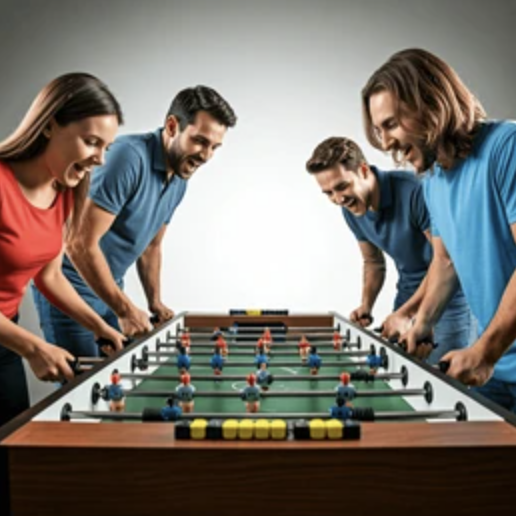

Top CLIP captions:
A man in jeans is playing with a ball while a woman in jeans stands nearby looking away .
Four people posing for a picture
Three women and one man are posing for a picture .
One man and three women pose for the camera .
Three people are facing the mountains .
A group of colorfully clothed people are sitting in a market .
Four people are posing outside .
Groups of people relax outside a building .
A three person band performs on a small stage .
Live band at underground cabana


In [22]:
from IPython.display import display
display(Image.open(UPLOADED_IMAGE))  # show uploaded image

# Use CLIP to retrieve top captions among all_texts for that uploaded image
proc = clip_processor(images=Image.open(UPLOADED_IMAGE).convert('RGB').resize((IMG_SIZE, IMG_SIZE)), return_tensors='pt').to(DEVICE)
with torch.no_grad():
    im_feat = clip_model.get_image_features(**proc)
    im_feat = F.normalize(im_feat, dim=-1).cpu().numpy()  # (1,D)
# compare to CLIP text embeddings we computed earlier (txt_embs from eval_clip_on_test)
# Note: compute_clip_embeddings returns arrays; reload if needed. For demo, recompute small set:
demo_texts = all_texts[:500]   # demo subset
_, demo_txt_embs = compute_clip_embeddings([IMAGES_DIR / i for i in test_imgs[:500]], demo_texts, batch_size=64)
sims = (im_feat @ demo_txt_embs.T).squeeze()
topk = sims.argsort()[::-1][:10]
print("Top CLIP captions:")
for k in topk:
    print(demo_texts[k])